# Multimodal Single-Cell Integration Competition: Data Exploration and Visualization

## 1. Setup Notebook

### 1.1. Import packages



In [1]:
#If you see a urllib warning running this cell, go to "Settings" on the right hand side, 
#and turn on internet. Note, you need to be phone verified.
!pip install --quiet tables

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1.2. Set filepaths

In [3]:
os.listdir("/kaggle/input/open-problems-multimodal/")

['sample_submission.csv',
 'train_cite_targets.h5',
 'test_multi_inputs.h5',
 'evaluation_ids.csv',
 'train_cite_inputs.h5',
 'train_multi_targets.h5',
 'train_multi_inputs.h5',
 'metadata.csv',
 'test_cite_inputs.h5']

In [4]:
DATA_DIR = "/kaggle/input/open-problems-multimodal/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

## 2. Load and Visualize Data

### 2.1. Cell Metadata

The metadata of our dataset comes is data about the cells. To understand the different groups of cells, let's first review how the experiment was conducted (see figure below):
1. On the first day (*day 1*), hemapoetic stem cells are cultured in a dish with liquids that trigger the differentation of these cells into blood cells.
2. On subsequent *days 2,3,4,7,10* some of the cells are removed and split into two subgroups `CITE` and `MULTIOME`.
3. Each of these assays (technologies) gives us two readouts per single cell: 
    1. CITEseq measures gene expression (RNA) and surface protein levels.
    2. Multiome measures gene expression (RNA) and chromatin accessibility (via ATACseq).

This experiment was repeated for 4 different donors of hemapoetic stem cells. The metadata gives information about day, donor, cell type,
and technology. `cell_id` is a unique cell identifier and has no meaning beyond its purpose as a cell id.

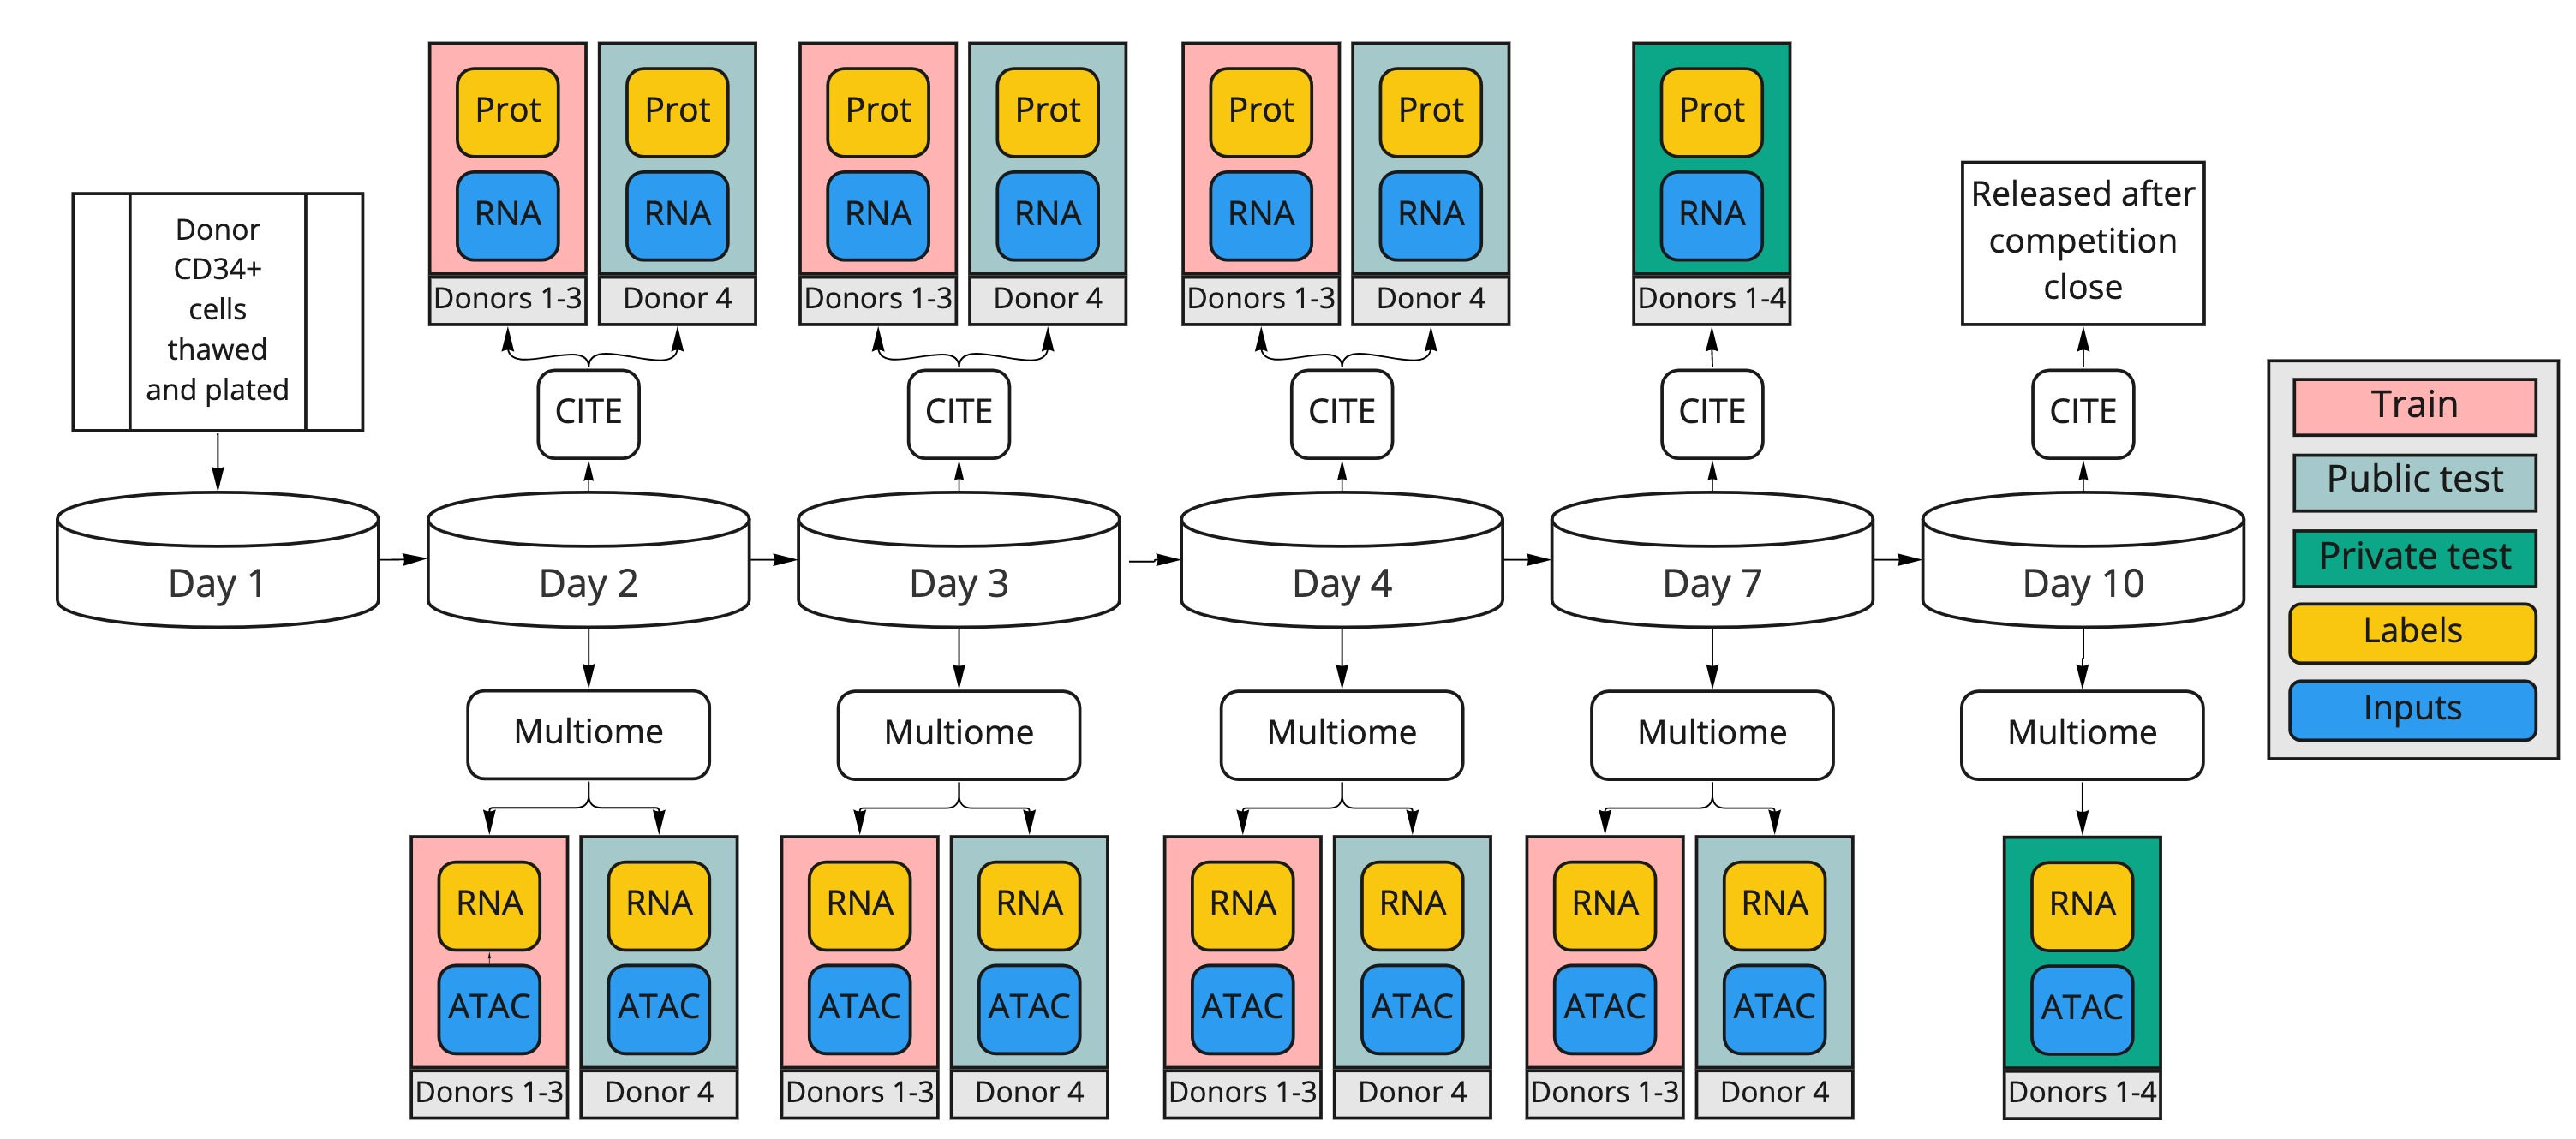

In [5]:
df_cell = pd.read_csv(FP_CELL_METADATA)
df_cell

,cell_id,day,donor,cell_type,technology
0,c2150f55becb,2,27678,HSC,citeseq
1,65b7edf8a4da,2,27678,HSC,citeseq
2,c1b26cb1057b,2,27678,EryP,citeseq
3,917168fa6f83,2,27678,NeuP,citeseq
4,2b29feeca86d,2,27678,EryP,citeseq
...,...,...,...,...,...
281523,96a60b026659,10,31800,hidden,multiome
281524,d493e546991e,10,31800,hidden,multiome
281525,05666c99aa48,10,31800,hidden,multiome
281526,121f946642b5,10,31800,hidden,multiome


**NOTE:** the cell type is hidden for the test set of the multiome as this can reveal information about the RNA.

**Let's split the cells by technology**

In [6]:
df_cell_cite = df_cell[df_cell.technology=="citeseq"]
df_cell_multi = df_cell[df_cell.technology=="multiome"]

**Number of cells per group:**

The number of cells in each group is relatively constant, around 7500 cells per donor and day.

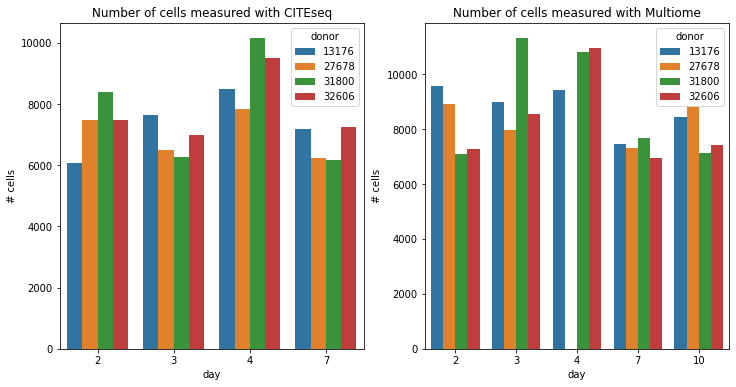

In [7]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
df_cite_cell_dist = df_cell_cite.set_index("cell_id")[["day","donor"]].value_counts().to_frame()\
                .sort_values("day").reset_index()\
                .rename(columns={0:"# cells"})
sns.barplot(data=df_cite_cell_dist, x="day",hue="donor",y="# cells", ax=axs[0])
axs[0].set_title("Number of cells measured with CITEseq")

df_multi_cell_dist = df_cell_multi.set_index("cell_id")[["day","donor"]].value_counts().to_frame()\
                .sort_values("day").reset_index()\
                .rename(columns={0:"# cells"})
sns.barplot(data=df_multi_cell_dist, x="day",hue="donor",y="# cells", ax=axs[1])
axs[1].set_title("Number of cells measured with Multiome")
plt.show()

### 2.2. Citeseq

For CITEseq, the task is to predict surface protein levels ("targets") from RNA expression levels ("inputs" of the model).

**Inputs:** For the RNA counts, each row corresponds to a cell and each column to a gene. The column format for a gene is given by `{EnsemblID}_{GeneName}` where `EnsemblID` refers to the [Ensembl Gene ID](https://www.ebi.ac.uk/training/online/courses/ensembl-browsing-genomes/navigating-ensembl/investigating-a-gene/#:~:text=Ensembl%20gene%20IDs%20begin%20with,of%20species%20other%20than%20human) and `GeneName` to the gene name.

In [8]:
df_cite_train_x = pd.read_hdf(FP_CITE_TRAIN_INPUTS)
df_cite_test_x = pd.read_hdf(FP_CITE_TEST_INPUTS)
df_cite_train_x.head()

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,4.090185,0.0
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.00000,0.000000,0.000000,0.0
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.0,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.00000,3.847321,3.847321,0.0
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.0,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.00000,3.436846,4.113780,0.0
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.0,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.51861,4.196826,3.518610,0.0


**Targets:** For the surface protein levels, each row corresponds to a cell and each column to a protein:

In [9]:
df_cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
df_cite_train_y.head()

gene_id,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.448390,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.323613,8.407108,0.131301,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,1.348692,4.888579,-0.279483,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,1.504426,12.391979,0.511394,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,0.777023,6.496499,0.279898,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445


**Donor and cell types:** The train data consists of both gene expression (RNA) and surface protein data for days 2,3,4 for donors 1-3 (donor IDs: `32606`,`13176`, and `31800`), the public test data consists of RNA for days 2,3,4 for donor 4 (donor ID: `27678`) and the private test data consists data from day 7 from all donors.

In [10]:
train_cells = df_cite_train_x.index.to_list()    
test_cells = df_cite_test_x.index.to_list()                                                     
df_cell_cite["split"] = ""
df_cell_cite.loc[df_cell_cite.cell_id.isin(train_cells),"split"] = "train"
df_cell_cite.loc[df_cell_cite.cell_id.isin(test_cells),"split"] = "test"

df_cell_cite[["split","day","donor"]].value_counts().to_frame().sort_values(["split","day","donor"]).rename(columns={0: "n cells"})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


n cells
split day donor         
test  2   27678     7476
      3   27678     6488
      4   27678     7832
      7   13176     7195
          27678     6247
          31800     6171
          32606     7254
train 2   13176     6071
          31800     8395
          32606     7476
      3   13176     7643
          31800     6259
          32606     6999
      4   13176     8485
          31800    10149
          32606     9511

### 2.3. Multiome

For the Multiome data set, the task is to predict RNA levels ("targets") from ATACseq.

**Inputs:** for the ATACseq data, each row corresponds to a cell and each column to a fragment of a gene.

<font fontsize=20 color="red"> **NOTE**: to save memory, we only read an excerpt from the ATACseq data!

In [11]:
START = int(1e5)
STOP = START+1000

df_multi_train_x = pd.read_hdf(FP_MULTIOME_TRAIN_INPUTS,start=START,stop=STOP)
df_multi_test_x = pd.read_hdf(FP_MULTIOME_TEST_INPUTS,start=START,stop=STOP)
df_multi_train_x.head()

gene_id,GL000194.1:114519-115365,GL000194.1:55758-56597,GL000194.1:58217-58957,GL000194.1:59535-60431,GL000195.1:119766-120427,GL000195.1:120736-121603,GL000195.1:137437-138345,GL000195.1:15901-16653,GL000195.1:22357-23209,GL000195.1:23751-24619,...,chrY:7722278-7723128,chrY:7723971-7724880,chrY:7729854-7730772,chrY:7731785-7732664,chrY:7810142-7811040,chrY:7814107-7815018,chrY:7818751-7819626,chrY:7836768-7837671,chrY:7869454-7870371,chrY:7873814-7874709
cell_id,,,,,,,,,,,,,,,,,,,,,
1777f8908031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7b88c4c3021b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34f17c8aece8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f02fabdccd4b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6083c6994d3e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Targets:** the RNA count data is in similar shape as the RNA count data from CITEseq:

In [12]:
df_multi_train_y = pd.read_hdf(FP_MULTIOME_TRAIN_TARGETS, start=START, stop=STOP)
df_multi_train_y.head()

gene_id,ENSG00000121410,ENSG00000268895,ENSG00000175899,ENSG00000245105,ENSG00000166535,ENSG00000256661,ENSG00000184389,ENSG00000128274,ENSG00000094914,ENSG00000081760,...,ENSG00000086827,ENSG00000174442,ENSG00000122952,ENSG00000198205,ENSG00000198455,ENSG00000070476,ENSG00000203995,ENSG00000162378,ENSG00000159840,ENSG00000074755
cell_id,,,,,,,,,,,,,,,,,,,,,
1777f8908031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,6.271747,0.0,0.000000,0.000000,0.000000
7b88c4c3021b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,4.251612,0.000000,0.0,0.0,5.627168,0.0,0.000000,4.251612,5.340685
34f17c8aece8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,5.349229,0.0,0.0,0.000000,0.0,4.660822,5.753109,0.000000
f02fabdccd4b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.606937,4.606937,...,0.000000,4.606937,0.000000,0.0,0.0,4.606937,0.0,0.000000,0.000000,0.000000
6083c6994d3e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,4.245897,0.000000,4.245897,0.0,0.0,0.000000,0.0,0.000000,0.000000,4.931858


**Donor and cell types:** The train data consists of both gene expression (RNA) and ATACseq data for days 2,3,4,7 for donors 1-3 (donor IDs: `32606`,`13176`, and `31800`), the public test data consists of RNA for days 2,3,4,7 for donor 4 (donor ID: `27678`) and the private test data consists data from day 7 from all donors.

<font fontsize=20 color="red"> **NOTE**: Uncomment the below cell if you have loaded the full ATACseq data!

In [13]:
# train_cells = df_multi_train_y.index.to_list()    
# test_cells = df_multi_test_y.index.to_list()                                                     
# df_cell_multi["split"] = ""
# df_cell_multi.loc[df_cell_multi.cell_id.isin(train_cells),"split"] = "train"
# df_cell_multi.loc[df_cell_multi.cell_id.isin(test_cells),"split"] = "test"

# df_cell_multi[["split","day","donor"]].value_counts().to_frame().sort_values(["split","day","donor"]).rename(columns={0: "n cells"})